In [1]:
import re
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_auc_score

## Loading the data

In [6]:
data_folder = '../data'
main_dataset = 'compas-scores.csv'

In [7]:
df = pd.read_csv(data_folder+ '/'+ main_dataset)

In [8]:
df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,vr_offense_date,vr_charge_desc,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,type_of_assessment,decile_score.1,score_text,screening_date
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,NaN,NaN,Risk of Violence,1,Low,2013-08-14,Risk of Recidivism,1,Low,2013-08-14
1,2,michael ryan,michael,ryan,2014-12-31,Male,1985-02-06,31,25 - 45,Caucasian,...,NaN,NaN,Risk of Violence,2,Low,2014-12-31,Risk of Recidivism,5,Medium,2014-12-31
2,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,2013-07-05,Felony Battery (Dom Strang),Risk of Violence,1,Low,2013-01-27,Risk of Recidivism,3,Low,2013-01-27
3,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,NaN,NaN,Risk of Violence,3,Low,2013-04-14,Risk of Recidivism,4,Low,2013-04-14
4,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,NaN,NaN,Risk of Violence,6,Medium,2013-01-13,Risk of Recidivism,8,High,2013-01-13


## Data engineering

Drop columns that provide no information for bias detection/feature selection.

In [7]:
columns_to_drop = ['last', 'first', 'vr_charge_degree', 'vr_case_number', 'num_vr_cases', 'c_days_from_compas', 'days_b_screening_arrest', 'juv_other_count', 'juv_misd_count', 'decile_score', 'juv_fel_count', 'vr_charge_desc', 'v_type_of_assessment', 'v_type_of_assessment', 'v_decile_score', 'v_score_text', 'type_of_assessment', 'decile_score.1', 'score_text']

df = df.drop(columns_to_drop, axis=1)

Drop columns that describe the case itself, thus are not representative for bias detection.

In [8]:
columns_to_drop = ['id', 'c_case_number', 'num_r_cases', 'r_case_number']

df = df.drop(columns_to_drop, axis=1)

Perform some data encoding.

In [9]:
df = df[df['is_recid'] != -1]
df = df[df['is_violent_recid'] != -1]

In [10]:
is_recid, is_violent_recid = df['is_recid'], df['is_violent_recid']

In [11]:
columns_to_drop = ['is_recid', 'is_violent_recid']

df = df.drop(columns_to_drop, axis=1)
df.head()

,name,compas_screening_date,sex,dob,age,age_cat,race,priors_count,c_jail_in,c_jail_out,...,c_charge_desc,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,vr_offense_date,v_screening_date,screening_date
0,miguel hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,0,2013-08-13 06:03:42,2013-08-14 05:41:20,...,Aggravated Assault w/Firearm,O,NaN,NaN,NaN,NaN,NaN,NaN,2013-08-14,2013-08-14
2,kevon dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,2013-01-26 03:45:27,2013-02-05 05:36:53,...,Felony Battery w/Prior Convict,F,NaN,2013-07-05,Felony Battery (Dom Strang),NaN,NaN,2013-07-05,2013-01-27,2013-01-27
3,ed philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,4,2013-04-13 04:58:34,2013-04-14 07:02:04,...,Possession of Cocaine,M,0.0,2013-06-16,Driving Under The Influence,2013-06-16,2013-06-16,NaN,2013-04-14,2013-04-14
4,marcu brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,1,NaN,NaN,...,Possession of Cannabis,O,NaN,NaN,NaN,NaN,NaN,NaN,2013-01-13,2013-01-13
5,bouthy pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,2,NaN,NaN,...,arrest case no charge,O,NaN,NaN,NaN,NaN,NaN,NaN,2013-03-26,2013-03-26


In [12]:
columns_to_drop_temp = ['age_cat', 'r_charge_degree' , 'r_days_from_arrest', 'name', 'c_arrest_date', 'compas_screening_date', 'c_charge_desc', 'r_charge_desc', 'dob', 'c_jail_in', 'c_jail_out', 'c_offense_date', 'r_offense_date', 'r_jail_in', 'r_jail_out', 'vr_offense_date', 'v_screening_date', 'screening_date']

df = df.drop(columns_to_drop_temp, axis=1)

In [13]:
df['sex'] = df['sex'].map({'Male':1, 'Female':0})

In [14]:
race_map = {'Other':0, 'Caucasian':1, 'African-American':2, 'Hispanic':3, 'Asian':4, 'Native American':5}
df['race'] = df['race'].map(race_map)

In [15]:
charge_degree_map = {'F':0, 'O':1, 'M':2}

df['c_charge_degree'] = df['c_charge_degree'].map(charge_degree_map)

Split data unto training and testing

In [16]:
train_x, test_x, train_y, test_y = train_test_split(df,
                                                is_recid,
                                                test_size = 0.20,
                                                random_state = 42)

Create a basic RandomForestClassifier model.

In [17]:
model = RandomForestClassifier(n_estimators = 25,
                               oob_score = True,
                               random_state = 1)

In [18]:
model.fit(train_x, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=1,
            oob_score=True, random_state=1, verbose=0, warm_start=False)

In [19]:
pred = model.predict(test_x)

In [20]:
print ("AUC-ROC (test) = ", roc_auc_score(test_y, pred))

AUC-ROC (test) =  0.5802369400630624


## Feature importance and feature selection

### Estimate variable importance

In [21]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel
import shap

In [22]:
shap.initjs()

Text(0.5,1,'Feature importance of RF model, trained on COMPAS dataset')

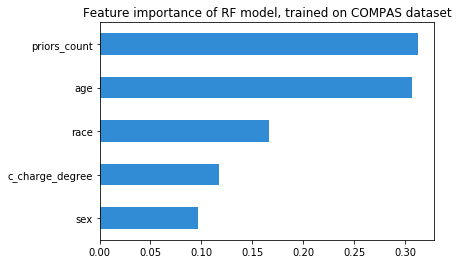

In [23]:
# Create interpreter for our testing data

interpreter = Interpretation(test_x, feature_names = df.columns)

# Load model in Skater memory

mem_model = InMemoryModel(model.predict_proba, examples = train_x)

# Generate feature importance plots 

plots = interpreter.feature_importance.plot_feature_importance(mem_model, ascending = True, progressbar=False)
ax = plots[1]
ax.set_title("Feature importance of RF model, trained on COMPAS dataset")

We see that **age** seems to be the second most important feature, even more important than **race**. It's probably because most of the data are younger people, so the model therefore chose this feature as important one.

**Sex** is not very important here, but the *inbalance between males/females* in the dataset is present.

**Priors count** is the most important feature, almost as important as the age. Probably, if we would have bigger dataset with different age groups and less inbalance the priors count would be the **most important feature.**

### The relationship between a variable and a models predictions

In [25]:
def plotNegativeClassFeatureRelation(feature_name, tick_labels_list = None, cust_title = None):
    mem_model = InMemoryModel(model.predict_proba, examples = train_x, 
                         target_names=['Probability of no recidive', 'Probability of recidive'])
    
    axes_list = interpreter.partial_dependence.plot_partial_dependence([feature_name], mem_model, grid_resolution=25, 
                                                                   with_variance=True, figsize = (8, 4), progressbar=False)
    ax = axes_list[0][1]
    
    title = 'Dependence between ' + feature_name + ' and predicted label'
       
    if(tick_labels_list != None):
        ax.set_xticklabels(tick_labels_list)

    ax.set_title(title)
    ax.set_ylim(0, 1)


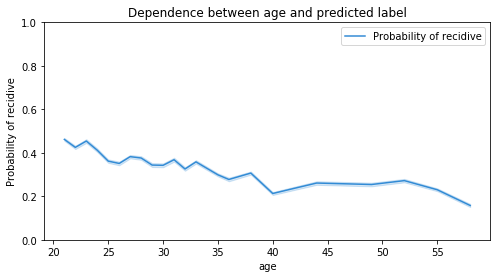

In [26]:
plotNegativeClassFeatureRelation('age')

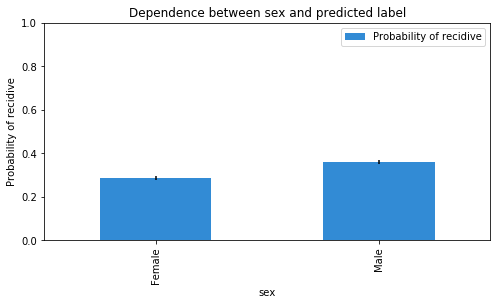

In [27]:
plotNegativeClassFeatureRelation('sex', ['Female', 'Male'])

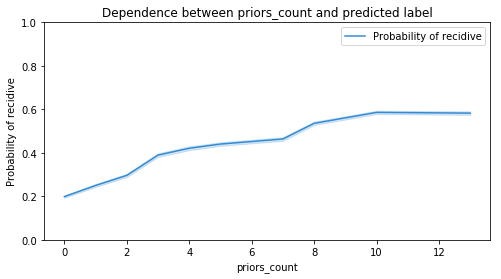

In [28]:
plotNegativeClassFeatureRelation('priors_count')

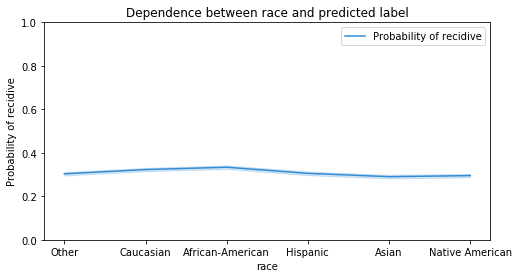

In [29]:
plotNegativeClassFeatureRelation('race', ['','Other', 'Caucasian', 'African-American', 
                                                   'Hispanic', 'Asian', 'Native American'])

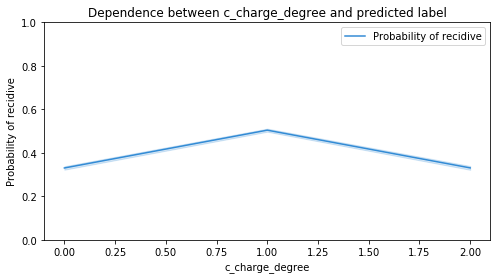

In [30]:
plotNegativeClassFeatureRelation('c_charge_degree')

## Correlation between features itself

In [31]:
def findDataFrameCorrelationsAndPlot(data_frame):
    plt.figure(figsize=(8,4))
    cor = df.corr()
    sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
    plt.show()

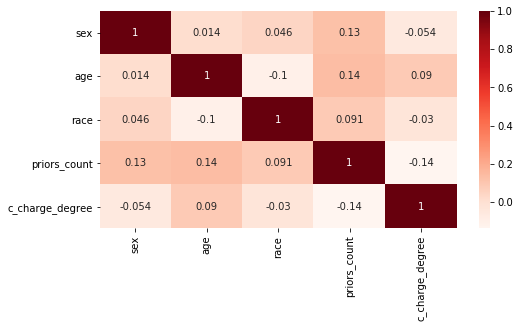

In [32]:
findDataFrameCorrelationsAndPlot(df)

## Shap values

In [34]:
# Build an explainer for a random forest model
explainer = shap.TreeExplainer(model)

# Compute SHAP values
shap_values = explainer.shap_values(test_x)

In [73]:
# Plot shap values

shap.force_plot(explainer.expected_value[0], shap_values[0], train_x)

In [83]:
# Shap dependence plot

shap.dependence_plot(shap_values, train_x)

TypeError: dependence_plot() missing 1 required positional argument: 'features'

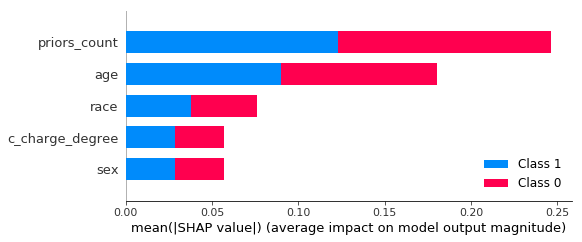

In [78]:
# SHAP summary plot

shap.summary_plot(shap_values, train_x, plot_type="bar")

## Testing custom pyscript

In [86]:
from feature_selector import FeatureSelector

In [87]:
feature_selector = FeatureSelector(model, train_x, test_x, train_y, test_y, df.columns)